In [1]:
import math
import numpy as np
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt

f64 = tf.float32

ep = tf.constant(0.1, dtype=f64)

In [2]:
mnist = input_data.read_data_sets("/tmp/data", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = mnist.train.images.T
Y_train = mnist.train.labels.T

X_test = mnist.test.images.T
Y_test = mnist.test.labels.T

0.0 0.0 0.0


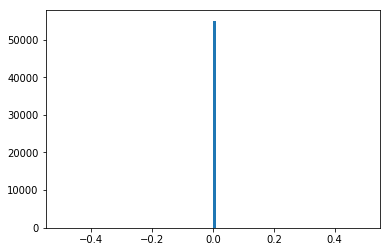

In [4]:
xs = X_train[0]
print(np.max(xs), np.min(xs), np.mean(xs))

plt.hist(xs, bins=100)
plt.show()

In [5]:
def normalize(X):
    mu = np.mean(X, axis=1)
    

In [6]:
def tprint(x, name=''):
    return tf.Print(x, [x], name)

In [7]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [8]:
def create_placeholders():
    X = tf.placeholder(dtype=f64, shape=[n_x, None], name='X')
    Y = tf.placeholder(dtype=f64, shape=[n_y, None], name='Y')
    return X, Y

In [9]:
def init_params(n_units, n_l):
    params = {
        'W': [tf.get_variable(name='W' + str(i+1),
                              shape=[n_units[i+1], n_units[i]], 
                              dtype=f64, 
                              initializer=tf.contrib.layers.xavier_initializer())
             for i in range(n_l)],
        
        'b': [tf.get_variable(name='b' + str(i+1),
                              shape=[n_units[i+1], 1], 
                              dtype=f64, 
                              initializer=tf.zeros_initializer())
             for i in range(n_l)]
    }
    return params

In [10]:
def forward_prop(X, params, g):
    A = X
    for i in range(len(g)):
        Z = tf.add(tf.matmul(params['W'][i], A), params['b'][i])
        A = g[i](Z)
    return A

In [11]:
def compute_cost(probs, Y):
    log_probs = -tf.log(probs)
    loss = tf.reduce_sum(tf.multiply(log_probs, Y), axis=0)
    cost = tf.reduce_sum(loss)
    n_examples = tf.size(loss)
    return cost, n_examples

In [12]:
def nn_model(X_train, Y_train, X_test, Y_test, hyper_params, print_cost = True):
    
    ops.reset_default_graph()
    
    learning_rate = hyper_params['learning_rate']
    hl_units = hyper_params['hl_units']
    minibatch_size = hyper_params['minibatch_size']

    n_x, m = X_train.shape
    n_y = Y_train.shape[0]
    
    n_units = [n_x] + hl_units + [n_y]
    
    n_l = len(n_units) - 1
    n_hl = n_l - 1
    
    costs = []
    
    X, Y = create_placeholders()
    
    params = init_params(n_units, n_l)
    
    probs = forward_prop(X, params, hyper_params['g'])
    
    cost, n_ex = compute_cost(probs, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        # Do the training loop
        for epoch in range(hyper_params['n_epochs']):

            epoch_cost = 0.
            total_ex = 0
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost, minibatch_ex = sess.run([optimizer, cost, n_ex], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost
                total_ex += minibatch_ex
            
            print(total_ex, m)
            epoch_cost /= total_ex

            # Print the cost every epoch
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(params)
        print ("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(probs), tf.argmax(Y))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [13]:
def predict(X, params, hyper_params):
    
    W = [tf.convert_to_tensor(Wi) for Wi in params['W']]
    b = [tf.convert_to_tensor(bi) for bi in params['b']]
        
    x = tf.placeholder("float", [X.shape[0], None])
    
    probs = forward_prop(x, params, hyper_params['g'])
    p = tf.argmax(probs)
    
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [14]:
n_x, n_y = X_test.shape[0], Y_test.shape[0]

hyper_params = {
    'n_epochs': 15,
    'minibatch_size': 1024,
    'learning_rate': 0.001,
    'hl_units': [100, 100, 100],
    'g': [tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.softmax],
}

55000 55000
Cost after epoch 0: 5.605372
55000 55000
Cost after epoch 1: 5.010328
55000 55000
Cost after epoch 2: 4.902774
55000 55000
Cost after epoch 3: 4.848741
55000 55000
Cost after epoch 4: 4.813605
55000 55000
Cost after epoch 5: 4.788394
55000 55000
Cost after epoch 6: 4.769865
55000 55000
Cost after epoch 7: 4.753736
55000 55000
Cost after epoch 8: 4.743026
55000 55000
Cost after epoch 9: 4.732431
55000 55000
Cost after epoch 10: 4.723517
55000 55000
Cost after epoch 11: 4.714677
55000 55000
Cost after epoch 12: 4.707821
55000 55000
Cost after epoch 13: 4.701764
55000 55000
Cost after epoch 14: 4.695558


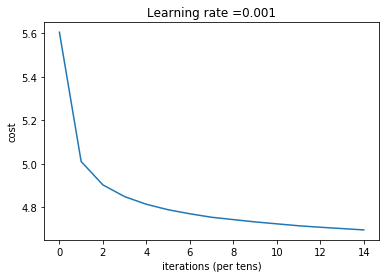

Parameters have been trained!
Train Accuracy: 0.988491
Test Accuracy: 0.9743


In [15]:
params = nn_model(X_train, Y_train, X_test, Y_test, hyper_params)

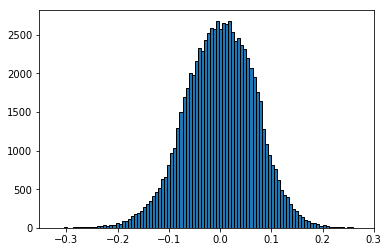

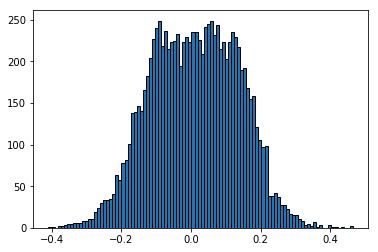

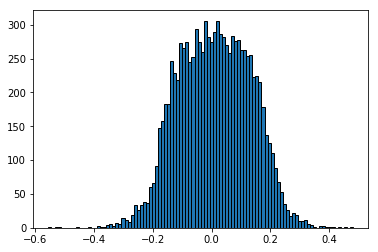

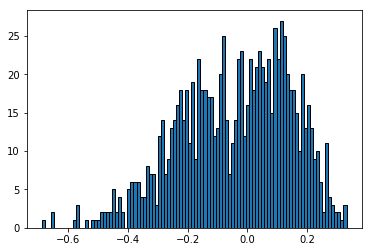

In [16]:
W = params['W']
for w in W:
    plt.hist(w.reshape(-1), 100, ec='black')
    plt.show()

211 211 211
4 6


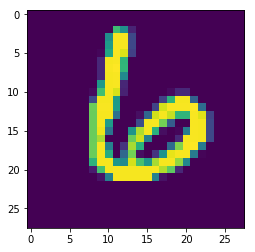

9 1


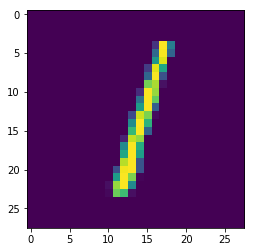

1 4


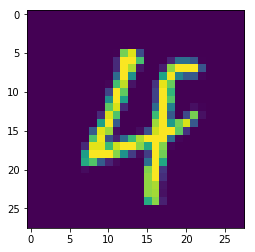

1 8


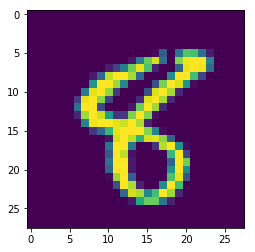

3 1


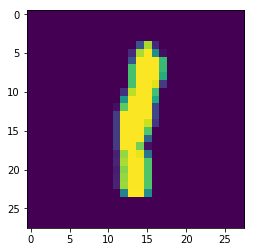

0 5


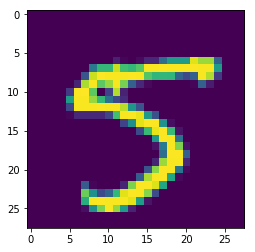

0 2


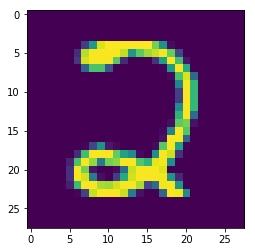

5 4


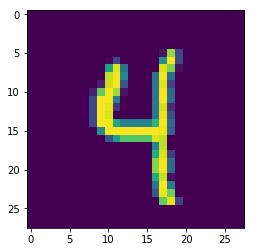

8 4


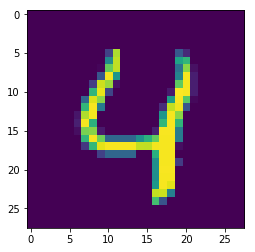

2 5


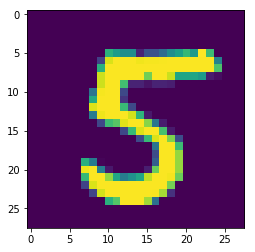

9 4


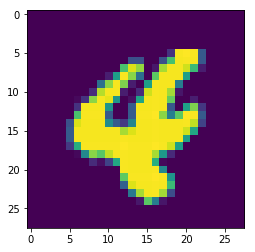

6 8


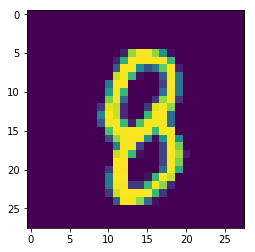

5 9


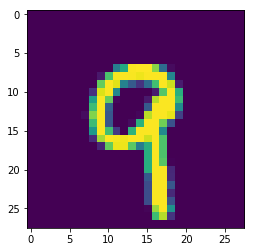

9 9


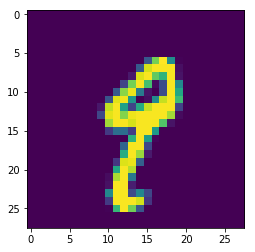

2 0


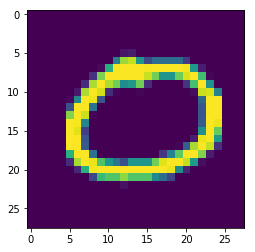

2 6


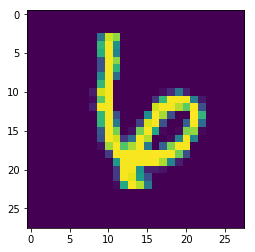

7 5


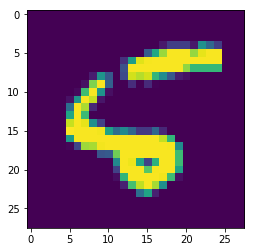

4 6


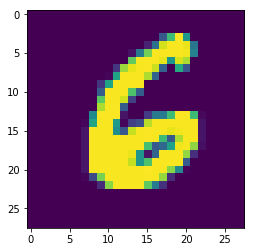

0 4


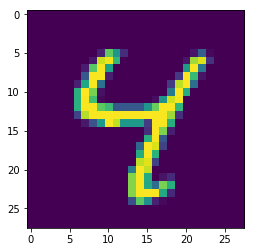

4 5


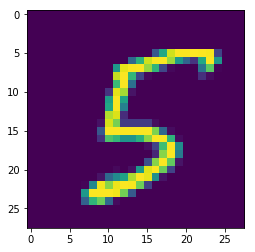

3 9


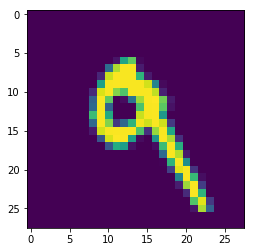

0 9


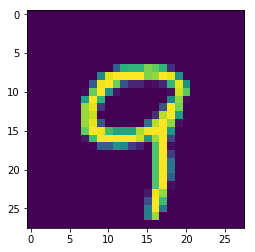

5 6


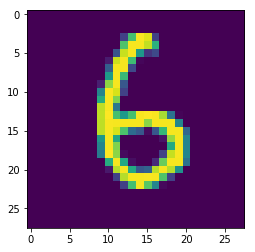

0 7


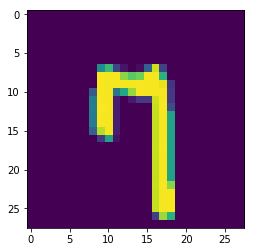

7 5


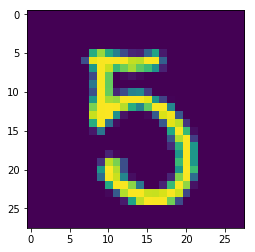

8 1


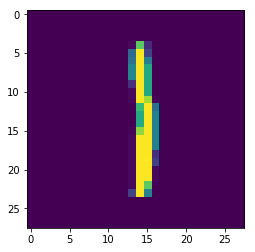

5 0


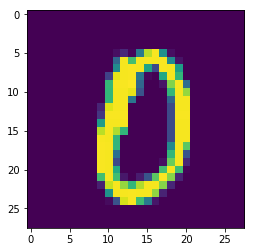

4 6


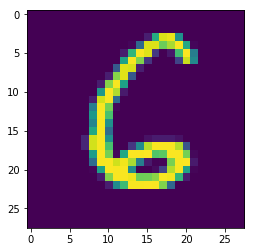

5 4


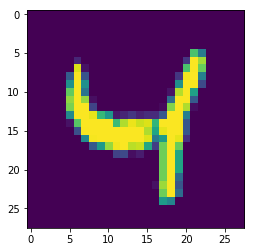

9 8


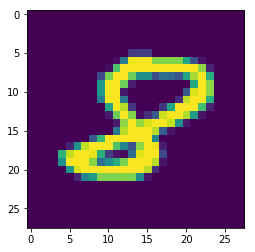

9 6


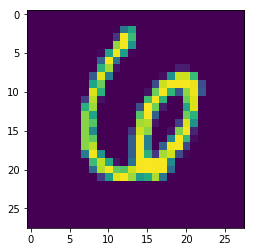

2 6


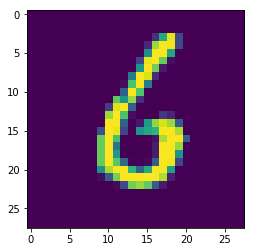

7 9


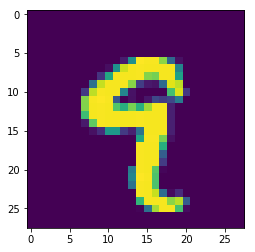

2 2


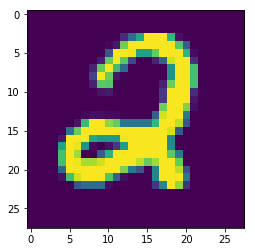

6 7


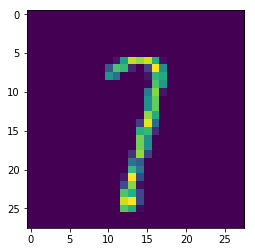

8 1


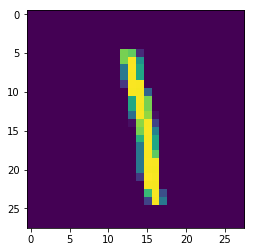

5 7


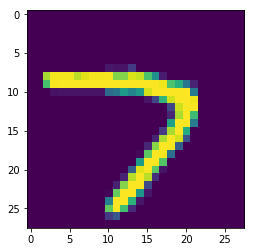

8 1


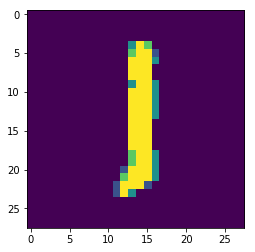

8 4


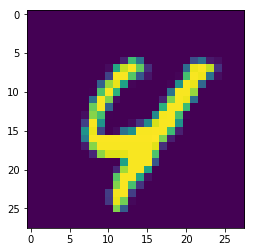

5 2


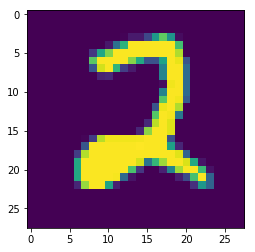

2 1


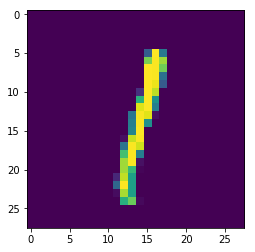

8 5


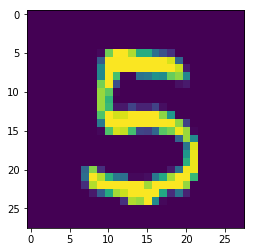

3 4


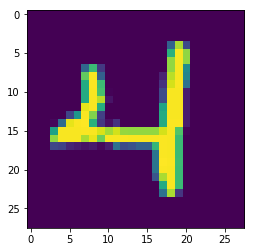

2 4


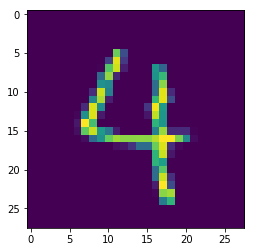

8 6


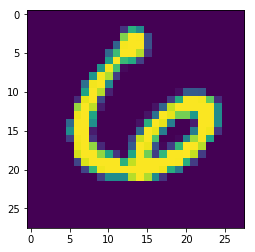

8 8


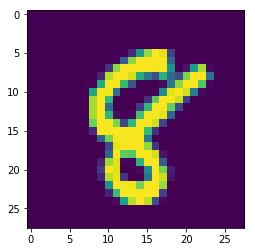

9 1


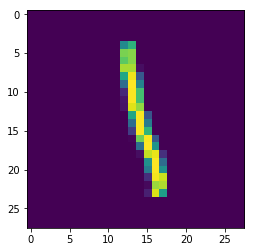

4 1


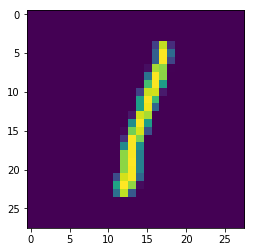

5 9


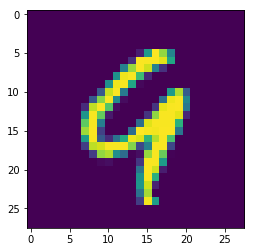

9 3


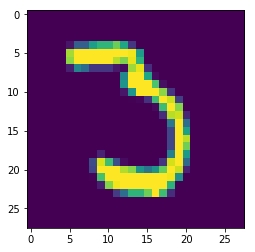

In [288]:
p_test = predict(X_test, params, hyper_params)
labels = np.argmax(Y_test, axis=0)

mask = p_test != labels

f_images = []
f_labels = []
f_pred = []
for i in range(len(labels)):
    if mask[i]:
        f_images.append(X_test[:, i])
        f_labels.append(labels[i])
        f_pred.append(p_test[i])

print(len(f_pred), len(f_images), len(f_labels))

n = len(f_labels)

indices = np.random.permutation(range(n))
indices = indices[:50]

for i in indices:
    print(wrong_pred[i], labels[i])
    img = X_test[:, i] * 25
    pp.imshow(img.reshape(28, 28))
    pp.show()

In [72]:
train_acc, test_acc, losses = model.train()
iterations = np.arange(len(losses))
pp.plot(iterations, losses)
pp.show()


AttributeError: 'function' object has no attribute 'train'

In [197]:
print(train_acc, test_acc)
pred, out, correct, casted_correct, acc = model.predict(X_test)

0.978727 0.9691


In [198]:
n_tests = X_test.shape[1]
k = 10
rindices = np.random.permutation(n_tests)[:10]

In [202]:
print(acc)
print(pred[rindices])
print(out[rindices])
print(correct[rindices])
print(casted_correct[rindices])
print(np.sum(casted_correct))
print(np.sum(correct))

correct = np.equal(pred, np.argmax(Y_test))
print(np.mean(correct))


# for i in rindices:
#     img = X_test[:, i]
#     pp.imshow(img.reshape(28, 28))
#     pp.show()
#     print(np.argmax(Y_test[:, i]), pred[i])

[ 0.  0.  0. ...,  0.  0.  0.]
[3 1 9 0 6 3 0 2 9 8]
[6 0 3 0 7 6 2 2 1 7]
[ True False False False False  True False False False False]
[ 0.  0.  0.  1.  0.  0.  0.  1.  0.  0.]
833.0
1196
0.1196


In [165]:
a = np.array([4, 5, 1, 4, 6, 3])
msk = a > 3
print(a[msk])


n_test = X_test.shape[1]

print(test_predict)
true_val = Y_train.argmax()

mask = test_predict != true_val 
wrong_pred = test_predict[mask]
images = X_test[:, mask] 
print(images.shape)

# indices = np.random.permutation(range(n_test))
# indices = indices[:50]
# for i in indices:
#     print(test_predict[i])
#     img = X_test[:, i]
#     pp.imshow(img.reshape(28, 28))
#     pp.show()

[4 5 4 6]


NameError: name 'test_predict' is not defined

In [ ]:
import tensorflow as tf

with